**_The notebook is structured in the following way:_**
- Read Malware Datasets.
- Split data to train, test, validation.
- Create Sequential model and add layers.
- Compile model and fit model on train data.
- Predict and test model.
- Evaluation for the Model.

**Importing Needed Liberies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
from pathlib import Path
import os
from random import randint
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Tensorflow and Keras
from keras import models
from keras.layers import Conv2D, Dense,MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D
import keras.preprocessing  as kp
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from keras.datasets import cifar10
from keras.models import Sequential
import tensorflow as tf
from keras.utils import np_utils

In [2]:
# Disable warnings
warnings.filterwarnings("ignore")

### Load Datasets

In [3]:
train_path = '../input/malimg/malimg_dataset/train'
valid_path = '../input/malimg/malimg_dataset/val'
test_path = '../input/malimg/malimg_dataset/test'

In [4]:
train_df = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(128,128), 
                                                   batch_size=64,color_mode="rgb")
valid_df = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(128,128), 
                                                   batch_size=64,color_mode="rgb")
valid_df = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(128,128), 
                                                   batch_size=64,color_mode="rgb")

Found 7459 images belonging to 25 classes.
Found 923 images belonging to 25 classes.
Found 957 images belonging to 25 classes.


In [5]:
aug = ImageDataGenerator(rotation_range=10,  
                         zoom_range = 0.1, 
                         width_shift_range=0.1,  
                         height_shift_range=0.1, 
                         rescale=1.0/255.0)

gen_train = aug.flow_from_directory(train_path,
                                    batch_size =64,
                                    class_mode = 'categorical', 
                                    target_size = (128, 128))

Found 7459 images belonging to 25 classes.


In [6]:
gen_valid = aug.flow_from_directory(valid_path, 
                                    batch_size =64,
                                    class_mode = 'categorical', 
                                    target_size = (128, 128))

Found 923 images belonging to 25 classes.


In [7]:
gen_test = aug.flow_from_directory(test_path,
                                batch_size =64,
                                class_mode = 'categorical', 
                                target_size = (128, 128))

Found 957 images belonging to 25 classes.


In [8]:
# get images and label of images from training dataset use for display some of dataset.
imgs, labels = next(gen_train)

In [9]:
# create label dictionary to use it know the type of malware (model use index(number not text))
label_dict = {value:key for key, value in gen_train.class_indices.items()}

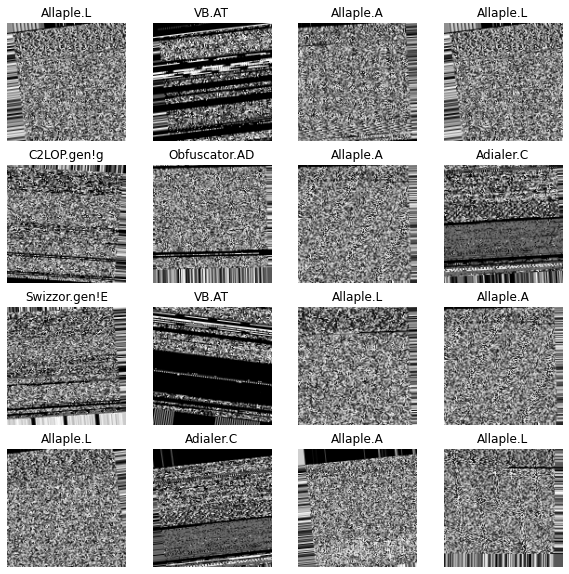

In [10]:
# create subplot for some sample of train data.
fig, ax = plt.subplots(4,4,figsize=(10,10))

# loop on new image predict and display.
for row in range(16):
    i = row//4
    j = row%4
    rand_index = randint(0, labels.shape[0]-1)
    ax[i, j].imshow(imgs[rand_index])
    ax[i, j].set_title(label_dict[np.where(labels[rand_index]!=0)[0][0]])
    ax[i, j].axis('off')

plt.show()

### CNN layers explain?

- **Convolutional layer**: A convolution is a mathematical term that describes a dot product multiply between two sets of elements array of image and kernel array.

- **MaxPooling layer**: Pooling is required to down sample the detection of features in feature maps, reduce the noise that happened from Convolutional Layers.

- **Flatten layer**: Takes an input shape and flattens the input image data into a one-dimension Dense Layer:

- **Dense Layer**: Fully connected layer, one dimension used in the last step in CNN.

- **Batch Normalization layer**:
    - Advantage of Batch Normalization layers: Makes sure that weights within the network do not become imbalanced with extreme values (reduce the ability of outlying large weights that will over-influence the training process).
    - Increase the training speed: reach with high accuracy in a smaller number of epochs.
    - When we use it? Use after Convolution layers.
- **Dropout**: add Dropout layers.
    - Why we use Dropout layers? prevent overfitting on the training data.
    - Found that the different between accuracy in train and test is reduced, so model is better with Dropout layer that make model more generalize.


In [11]:
# create CNN Sequential model.
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3, 3),
                 input_shape=(128, 128, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))

# BatchNormalization use to 
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                 kernel_initializer='he_uniform',
                 activation='relu', padding='same'))

model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3),
                 kernel_initializer='he_uniform',
                 activation='relu', padding='same'))

model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3),
                 kernel_initializer='he_uniform',
                 activation='relu', padding='same'))

model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3),
                 kernel_initializer='he_uniform',
                 activation='relu', padding='same'))

model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3),
                 kernel_initializer='he_uniform',
                 activation='relu', padding='same'))

model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform',))
model.add(Dropout(0.25))
model.add(Dense(25, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

### Compile model and fit model on train data.

In [12]:
# compile model and create callback list use to train model.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# use to early stop model before finish epoch to protect model from overfitting.
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# use to store best epoch weights for model to can use it to predict test dataset
checkpoint = tf.keras.callbacks.ModelCheckpoint("weights.hdf5",
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', verbose=1)
# check if need to add early stop to callback list or not.
call_backs = [early_stop, checkpoint, reduce_lr]

In [13]:
history = model.fit(gen_train, validation_data=gen_valid, 
                    epochs=25, batch_size=128, callbacks=call_backs)

Epoch 1/25
117/117 [==============================] - 101s 792ms/step - loss: 3.0941 - accuracy: 0.3726 - val_loss: 3.8941 - val_accuracy: 0.2871

Epoch 00001: val_accuracy improved from -inf to 0.28711, saving model to weights.hdf5
Epoch 2/25
117/117 [==============================] - 48s 410ms/step - loss: 1.4720 - accuracy: 0.5210 - val_loss: 3.0105 - val_accuracy: 0.3174

Epoch 00002: val_accuracy improved from 0.28711 to 0.31744, saving model to weights.hdf5
Epoch 3/25
117/117 [==============================] - 48s 409ms/step - loss: 1.3106 - accuracy: 0.5656 - val_loss: 2.6663 - val_accuracy: 0.4215

Epoch 00003: val_accuracy improved from 0.31744 to 0.42145, saving model to weights.hdf5
Epoch 4/25
117/117 [==============================] - 48s 406ms/step - loss: 1.1796 - accuracy: 0.6167 - val_loss: 1.9569 - val_accuracy: 0.4485

Epoch 00004: val_accuracy improved from 0.42145 to 0.44854, saving model to weights.hdf5
Epoch 5/25
117/117 [==============================] - 48s 408m

### Predict and test model.

In [14]:
# calculate test accuracy and loss.
test_loss, test_acc = model.evaluate_generator(gen_test, steps=50)
print('Test Accuracy:', round(test_acc*100,2),"%")
print('Test Loss:',test_loss)

Test Accuracy: 83.59 %
Test Loss: 1.355810523033142


In [15]:
# restor parameter for best epoch and predict test data.
model.load_weights('./weights.hdf5')

In [16]:
imgs, labels = next(gen_test)

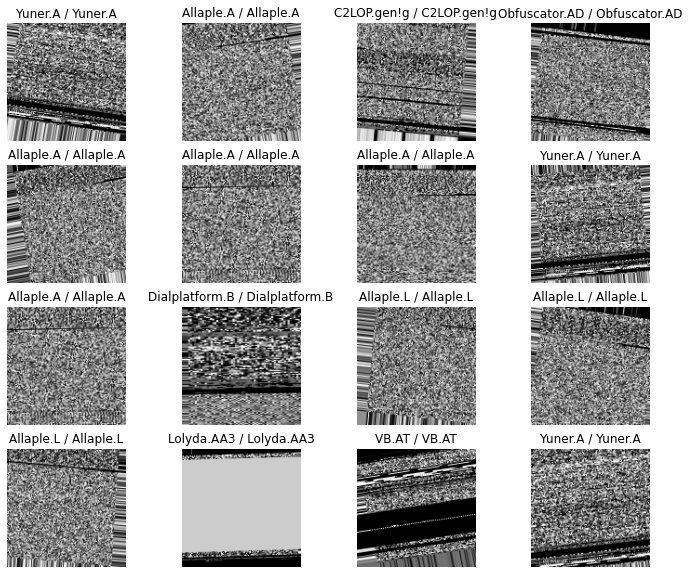

In [17]:
# create subplot for outside image.
fig, ax = plt.subplots(4,4,figsize=(12,10))

# loop on new image predict and display.
for row in range(16):
    i = row//4
    j = row%4
    rand_index = randint(0, labels.shape[0]-1)
    ax[i, j].imshow(imgs[rand_index])
    label_key = np.argmax(model.predict(np.expand_dims(imgs[rand_index],axis=0)))
    ax[i, j].set_title(label_dict[label_key]+" / "+label_dict[np.where(labels[rand_index]!=0)[0][0]])
    ax[i, j].axis('off')

plt.show()

### Evaluate the model.

**Loss With epochs for Train and Validation Data**

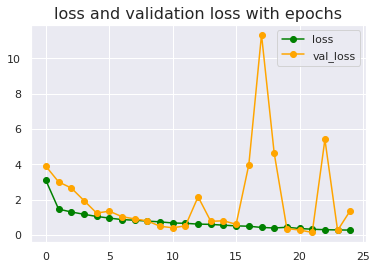

In [18]:
sns.set()
# plot loss function for train and validation.
plt.title('loss and validation loss with epochs', 
          fontsize=16)

plt.plot(history.history['loss'],
         marker='o',
         color="green",
         label="loss")

plt.plot(history.history['val_loss'],
         marker='o',
         color="orange", 
         label="val_loss")

plt.legend()
plt.show()

**Accuracy With epochs for Train and Validation Data**

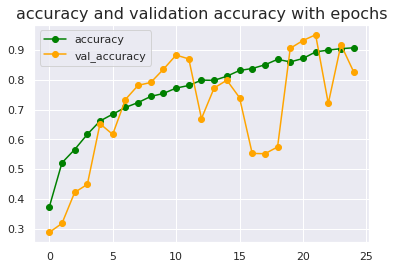

In [19]:
# plot accuracy for train and validation data.
plt.title('accuracy and validation accuracy with epochs',
          fontsize=16)

plt.plot(history.history['accuracy'],
         marker='o',
         color="green",
         label="accuracy")

plt.plot(history.history['val_accuracy'],
         marker='o',
         color="orange",
         label="val_accuracy")

plt.legend()
plt.show()

**ROC Metrics**

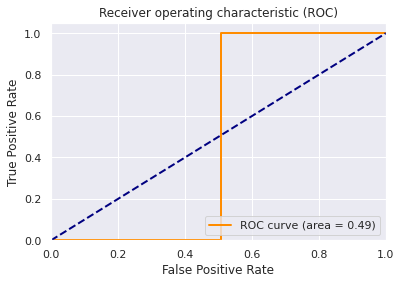

In [20]:
x, y = gen_train.next()
prediction = model.predict(x)

classes = np.argmax(prediction, axis=-1)
true_label1 = np.argmax(y, axis=-1)

y_true = np.array(true_label1)

y_pred = np.array(classes)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=9)
roc_auc = metrics.auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Confusion Matrix**

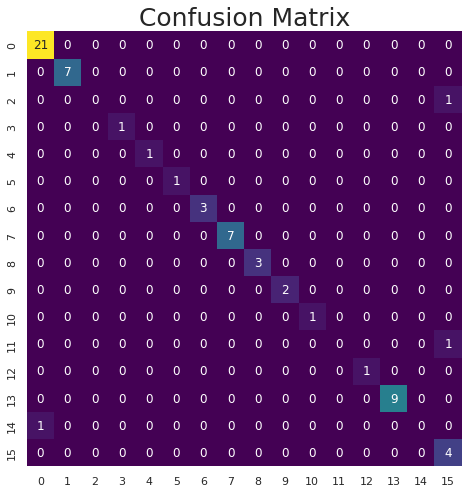

In [21]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
plt.title("Confusion Matrix",fontsize=25)
sns.heatmap(cm, fmt='d', cmap='viridis', annot = True, square=True, cbar=False)
plt.show()

**F1 Score**

In [22]:
# F1 Score = 2 * ((Precision * Recall)/ (Precision + Recall))
f1 = f1_score(y_true, y_pred, average='macro')*100
print('F1 score: %f' % f1)

F1 score: 79.854651


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [24]:
precision_score(y_true, y_pred, average="macro")*100

78.88257575757575

In [25]:
recall_score(y_true, y_pred,average="macro")*100

81.25

### Thanks